## Part II - Exploratory Data Analysis

University of San Diego - MS Applied AI

AAI-540 Team 5

October 21, 2024

In [14]:
!pip install awswrangler

  Using cached awswrangler-3.9.1-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.9.1-py3-none-any.whl (381 kB)


In [15]:
# Import libraries
import boto3
import sagemaker
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import awswrangler as wr

In [6]:
# initialize Sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

### Load raw data from datalake and interrogate

In [9]:
%store -r s3_datalake_path_csv

In [10]:
s3_datalake_path_csv

's3://sagemaker-us-east-1-053585949834/store-sales-forecasting/csv'

In [47]:
# Load data
holidays_df = wr.s3.read_csv(s3_datalake_path_csv + "/holidays_events.csv")
oil_df = wr.s3.read_csv(s3_datalake_path_csv + "/oil.csv")
transactions_df = wr.s3.read_csv(s3_datalake_path_csv + "/transactions.csv")
stores_df = wr.s3.read_csv(s3_datalake_path_csv + "/stores.csv")
sales_df = wr.s3.read_csv(s3_datalake_path_csv + "/train.csv")

In [20]:
# Display first 5 rows and column attributes
display(stores_df.head())
stores_df.info()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [21]:
# show unique states
unique_states = stores_df['state'].unique()
unique_states

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

In [22]:
# show unique cities
unique_city = stores_df['city'].unique()
unique_city

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [23]:
# show unique type
stores_df['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

#### Inspect Holidays

Contains date and type of holiday for the date range of interest

In [24]:
# Convert dates to datetime
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Display first 5 rows and column attributes
display(holidays_df.head())
holidays_df.info()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [25]:
holidays_df['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [26]:
# inspect date range and time steps for holidays
print("Date range for holidays:")
print("Start date: {}".format(holidays_df['date'].min()))
print("End date: {}".format(holidays_df['date'].max()))

Date range for holidays:
Start date: 2012-03-02 00:00:00
End date: 2017-12-26 00:00:00


In [27]:
holidays_df['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [28]:
# get unique locale_names
unique_locales = holidays_df['locale_name'].unique()
unique_locales

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [29]:
# check for matches/overlap with holidays state values
for locale in unique_locales:
    if ((locale not in unique_city) and (locale not in unique_states)):
        print("Locale did not match city or state: {}".format(locale))


Locale did not match city or state: Ecuador


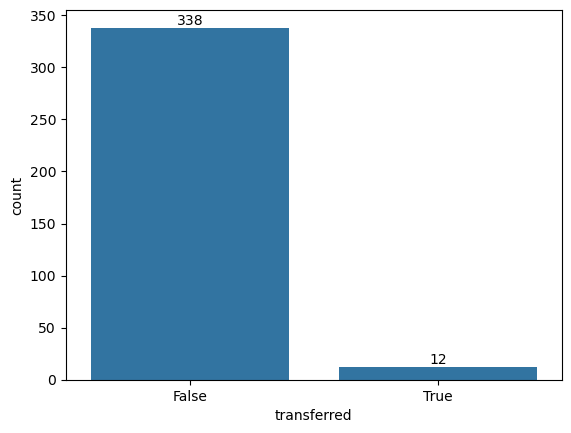

In [30]:
ax = sns.countplot(data=holidays_df, x='transferred')
ax.bar_label(ax.containers[0])
plt.show()

##### **Notes on Holidays and Locales**

The holidays seem to corrleate to either city or state level with one exception.  This would indicate that holidays can be mapped to stores based on these values - that is a holiday would be releveant to a store on a certain date if the locale matched either the city or state of the store.  This should be faciliated through the feature engineering process.

#### Inspect Oil data

Contains the daily price of oil over the date range of interest

In [31]:
# Convert dates to datetime
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Display first 5 rows and column attributes
display(oil_df.head())
oil_df.info()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [32]:
# inspect date range and time steps for Oil
print("Time series summary for oil:")
print("Start date: {}".format(oil_df['date'].min()))
print("End date: {}".format(oil_df['date'].max()))
print("Number of time steps: {}".format(len(oil_df['date'].unique())))

Time series summary for oil:
Start date: 2013-01-01 00:00:00
End date: 2017-08-31 00:00:00
Number of time steps: 1218


In [33]:
# Check if the dates are consecutive
nonconsecutive_dates = len(oil_df[oil_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for oil: {nonconsecutive_dates}")

Number of nonconsecutive dates for oil: 243


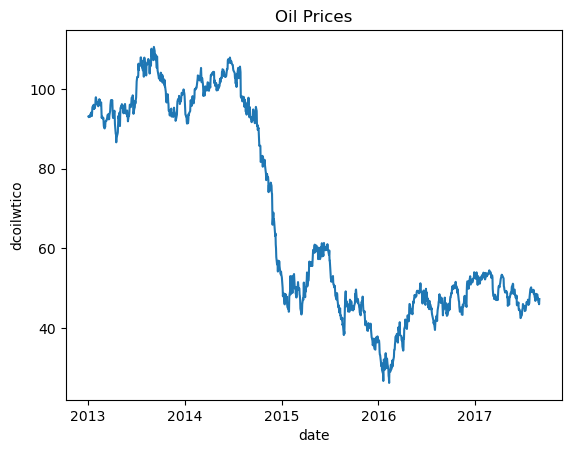

In [34]:
# visualize oil prices
sns.lineplot(data=oil_df, x='date', y='dcoilwtico')
plt.title('Oil Prices')
plt.show()

In [35]:
# Impute the missing values for oil prices by backfilling them
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].bfill()
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1218 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


##### **Notes on Oil Prices**

The oil dataset provides the daily price of oil for the date range of interest for our store sales.  The price of oil can be engineered as a feature to be included with each sample at the day level.

Juliet: Since oil prices don't change significantly from day to day, I used a backward fill to impute the missing values. Another thing to note is that not all of the dates are consecutive, so when merging this data with the other data we have to decide whether to treat the dates that are not included as missing values or not.

#### Inspect Transactions

In [36]:
# Convert dates to datetime
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Display first 5 rows and column attributes
display(transactions_df.head())
transactions_df.info()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [37]:
# inspect date range and time steps for Transactions
print("Time series summary for transactions:")
print("Start date: {}".format(transactions_df['date'].min()))
print("End date: {}".format(transactions_df['date'].max()))
print("Number of time steps: {}".format(len(transactions_df['date'].unique())))

Time series summary for transactions:
Start date: 2013-01-01 00:00:00
End date: 2017-08-15 00:00:00
Number of time steps: 1682


In [38]:
# Check if there are nonconsecutive dates
nonconsecutive_dates = len(transactions_df[transactions_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for transactions: {nonconsecutive_dates}")

Number of nonconsecutive dates for transactions: 6


In [39]:
# create a grouped df by store to visualize
transactions_df_grouped = transactions_df.groupby(['store_nbr', pd.Grouper(key='date', freq='D')]).max()

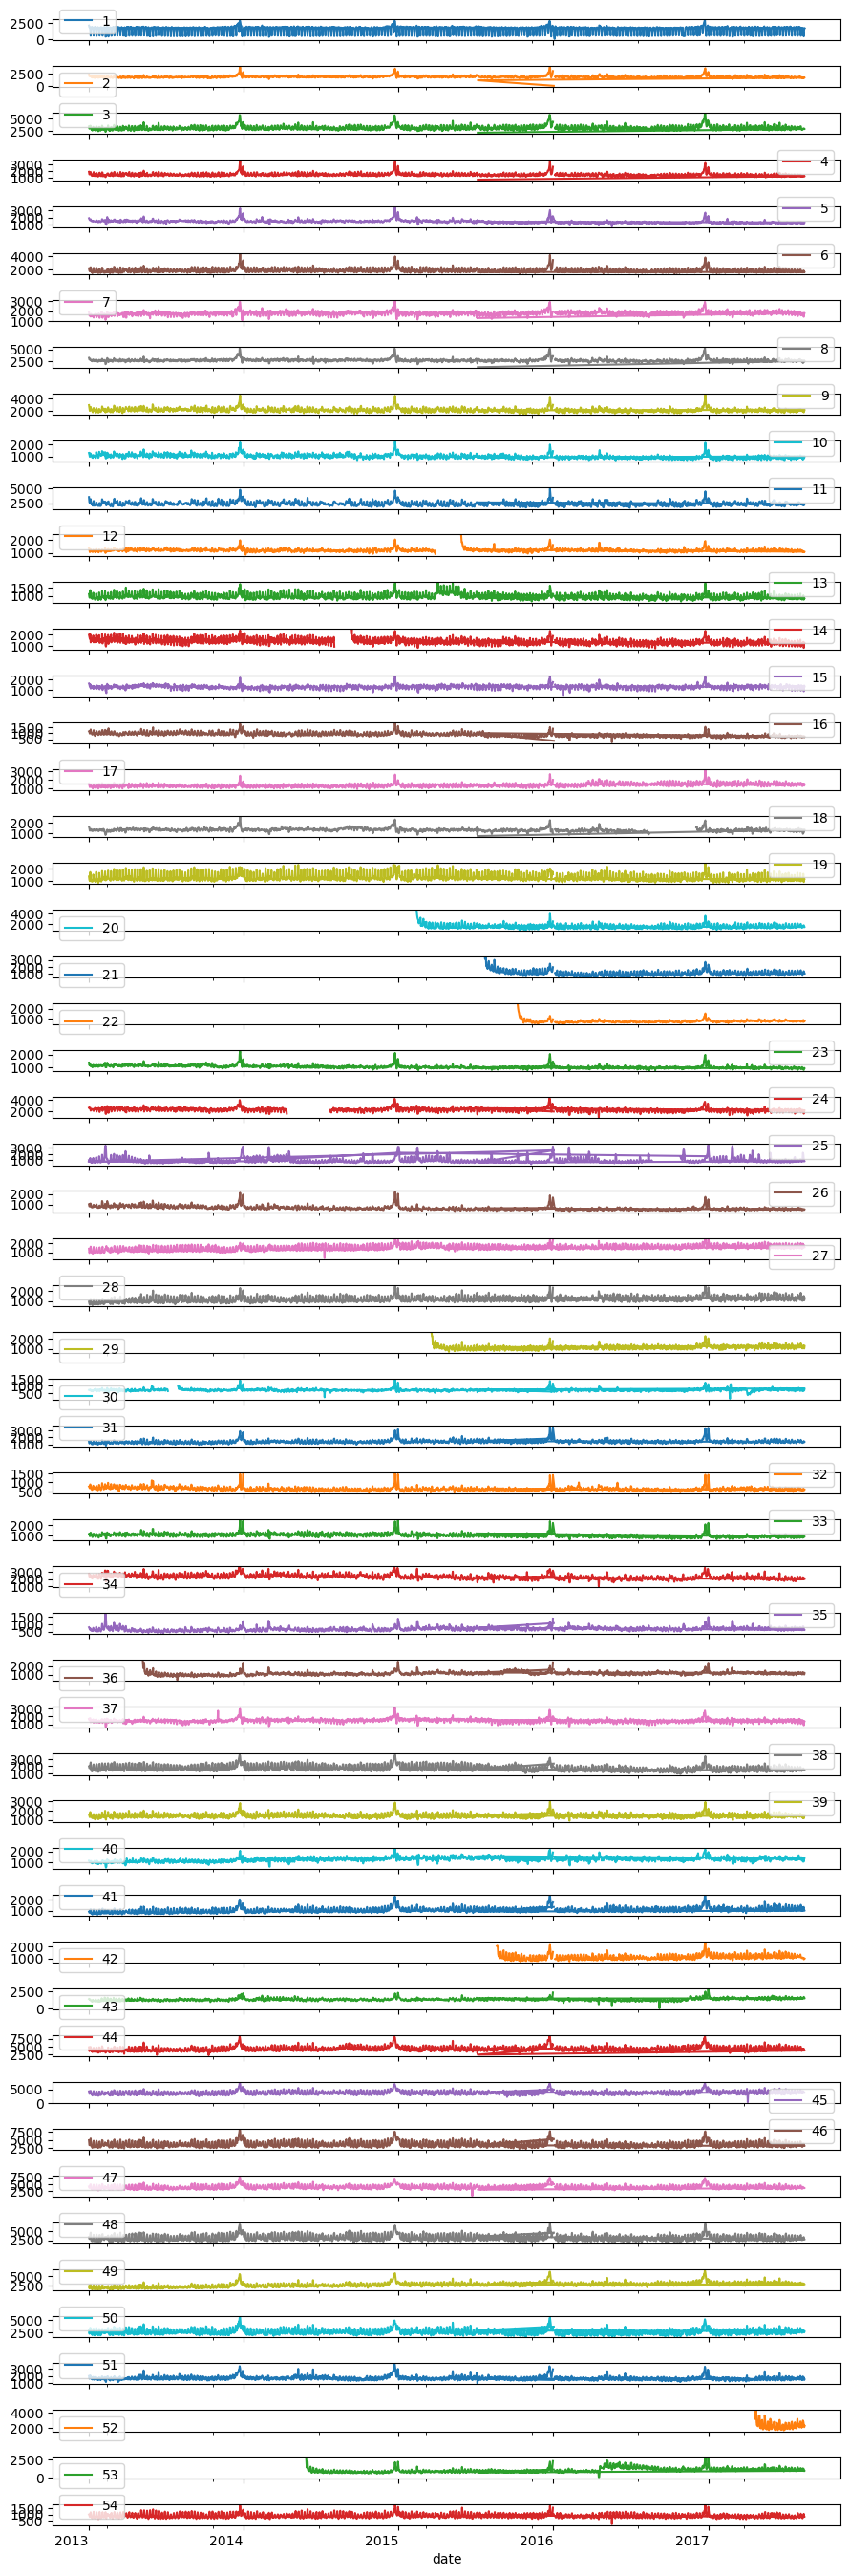

In [40]:
# plot total transactions by store
ax = transactions_df_grouped.unstack(level=0).plot(kind='line', y='transactions', subplots=True, rot=0, figsize=(9, 27))
plt.tight_layout()

##### **Notes on Transactions**

Several observations can be made based on the exploration and visualization of the transaction data:

1.  The data is collected at a 1 day resolution at the store level.
2. We clearly have several stores that came online during our time period of interest.  We will need to take this into consideration when creating sequences for these stores (ie: Stores 20, 21, 22 as examples)
3. There are some cases where data is missing.  For example, Store 25 shows a clear data gap around late 2016.  This will also need to be handled in data preparation.
4.  We can clearly see seasonal spikes in the volume of transactions around the holiday at the end of each year.

Juliet: We could consider using transactions as the target instead of sales.

#### Inspect Store Sales

In [48]:
# Convert dates to datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Display first 5 rows and column attributes
display(sales_df.head())
sales_df.info()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [49]:
# Drop the id column
sales_df.drop(columns=['id'], inplace=True)

In [50]:
# inspect date range and time steps for sales
print("Time series summary for sales:")
print("Start date: {}".format(sales_df['date'].min()))
print("End date: {}".format(sales_df['date'].max()))
print("Number of time steps: {}".format(len(sales_df['date'].unique())))

Time series summary for sales:
Start date: 2013-01-01 00:00:00
End date: 2017-08-15 00:00:00
Number of time steps: 1684


In [51]:
# Check if there are nonconsecutive dates
nonconsecutive_dates = len(sales_df[sales_df['date'].diff() > pd.Timedelta('1 days')])
print(f"Number of nonconsecutive dates for sales: {nonconsecutive_dates}")

Number of nonconsecutive dates for sales: 4


In [52]:
# inspect how many stores
print("Number of stores: {}".format(len(sales_df['store_nbr'].unique())))

Number of stores: 54


In [53]:
# inspect how many product categories
print("Number of product categories: {}".format(len(sales_df['family'].unique())))

Number of product categories: 33


In [54]:
# create a grouped df by store to visualize
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df_grouped = sales_df.groupby(['store_nbr', pd.Grouper(key='date', freq='D')]).sum()

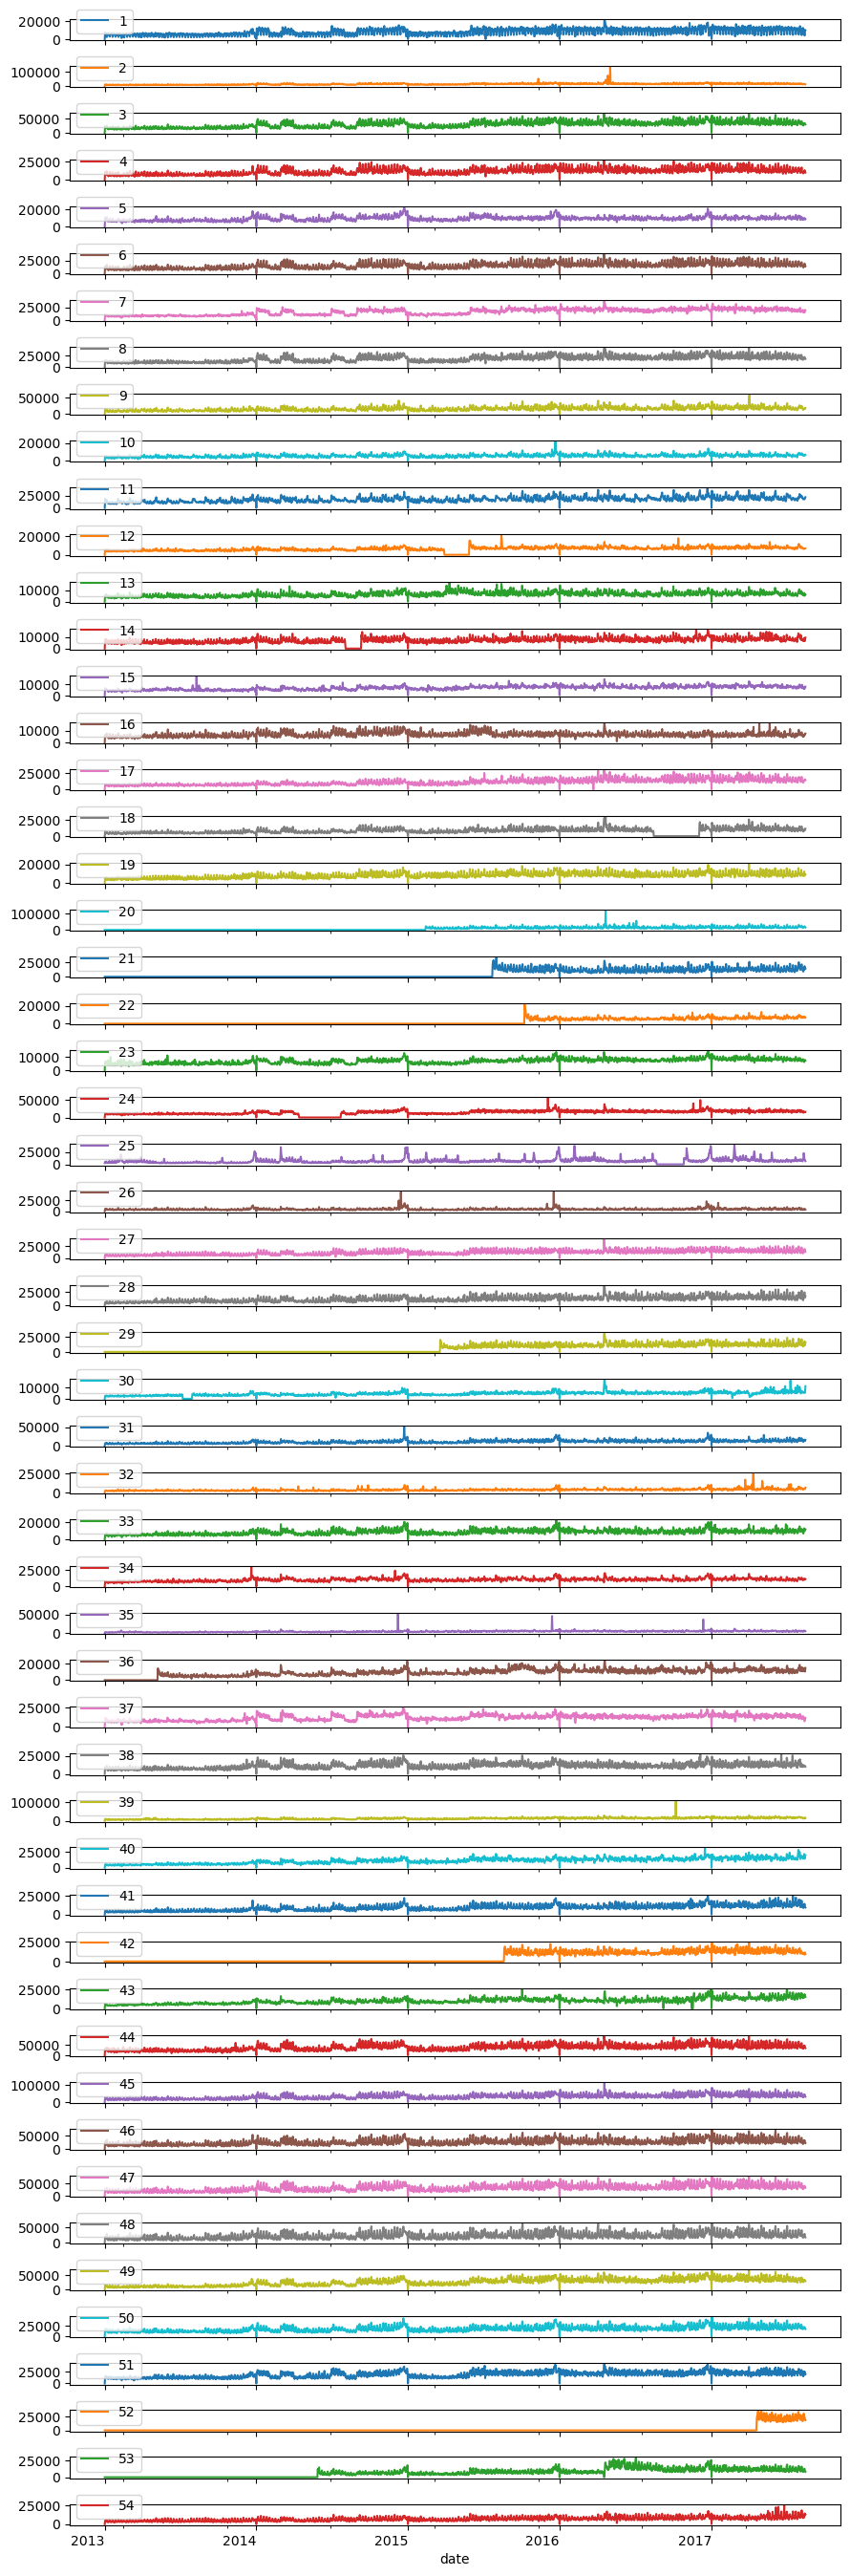

In [55]:
# plot total sales by store
ax = sales_df_grouped.unstack(level=0).plot(kind='line', y='sales', subplots=True, rot=0, figsize=(9, 27))
plt.tight_layout()

##### **Notes on Store Sales**

The store data was rolled up to total sales at a store level, not broken down by product category to aid in visualization.  Several observations can be made based on the exploration and visualization of the store sales data:

1. The sales data is similarly on a daily time step.  However, store data is further broken down by product category (not visualized in the graphs).
1. As observed in transactions, we clearly have several stores that came online during our time period of interest.  We will need to take this into consideration when creating sequences for these stores (ie: Stores 52 and 53 as examples)
2. The same data gaps are present for what appears to be the same stores as observed in the transactions data.
3.  There seems to be a more gradual ramp of sales leading up to the holidays, followed by a drop at the beginning of each year.

**General Notes**

Based on EDA so far, an approach for data loading and preparation is presenting itself.  One possible approach could look like the following:

1.   Load all data into a datalake
2.   Extract all unique locales from holiday dataset into additional metadata table
3.   Create index fields in both store table and holiday table to reference the appropriate locale ID
4.   Create an index field to link store_br in transactions and sales to stores metadata table
5.   Create a query that returns a view of the sales data that for each sales data sample:
    
    a) Store metadata/locale is pulled from store metadata (by store_nbr)
    b) Whether there is a holiday or not is pulled from holiday (by locale)
    c) Price of oil data for that day is pulled from oil table (by date)
    d) Number of transactions for the store is pulled from transactions (by store_nbr + date)


### Release resources

In [56]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}